# Deep Learning

## Weather Classification

### Importing Libraries

In [5]:
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import ResNet50
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, auc
from sklearn.preprocessing import label_binarize

Data pre proccesing

In [6]:
dataset_dir = r"C:\Users\LENOVO\Downloads\Dl project\dataset"
total_files = len(os.listdir(dataset_dir))
print(f'Total files in dataset: {total_files}')

Total files in dataset: 11


In [7]:
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    print(f'Number of images in {folder}: {len(files)}')
    print(f"First 5 files in {folder}: {files[:5]}")

Number of images in dew: 698
First 5 files in dew: ['2208.jpg', '2209.jpg', '2210.jpg', '2211.jpg', '2212.jpg']
Number of images in fogsmog: 851
First 5 files in fogsmog: ['4075.jpg', '4076.jpg', '4077.jpg', '4078.jpg', '4079.jpg']
Number of images in frost: 475
First 5 files in frost: ['3600.jpg', '3601.jpg', '3602.jpg', '3603.jpg', '3604.jpg']
Number of images in glaze: 639
First 5 files in glaze: ['6090.jpg', '6091.jpg', '6092.jpg', '6093.jpg', '6094.jpg']
Number of images in hail: 591
First 5 files in hail: ['0000.jpg', '0001.jpg', '0002.jpg', '0003.jpg', '0004.jpg']
Number of images in lightning: 377
First 5 files in lightning: ['1830.jpg', '1831.jpg', '1832.jpg', '1833.jpg', '1834.jpg']
Number of images in rain: 526
First 5 files in rain: ['1011.jpg', '1013.jpg', '1017.jpg', '102.jpg', '1021.jpg']
Number of images in rainbow: 232
First 5 files in rainbow: ['0592.jpg', '0593.jpg', '0594.jpg', '0595.jpg', '0596.jpg']
Number of images in rime: 1160
First 5 files in rime: ['4930.jpg'

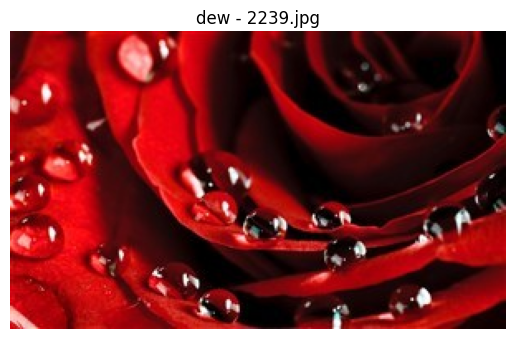

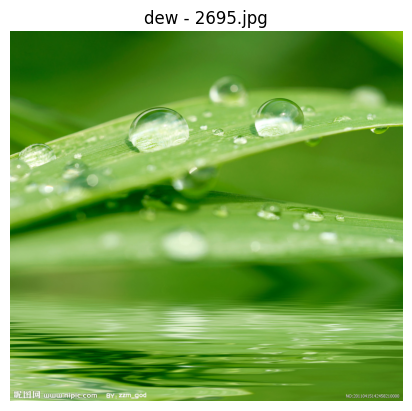

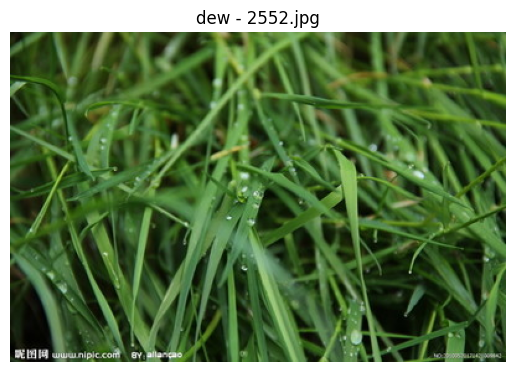

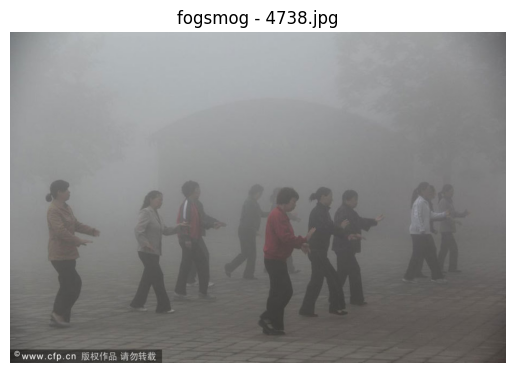

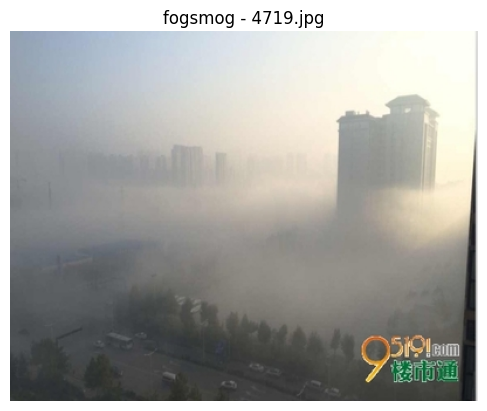

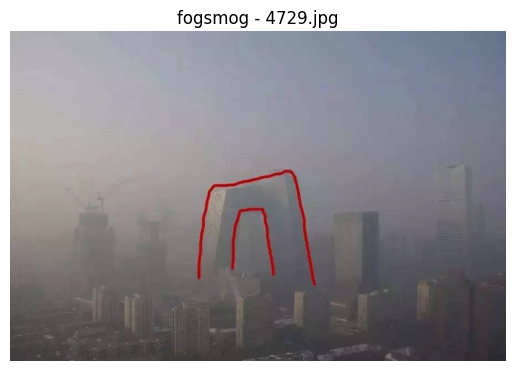

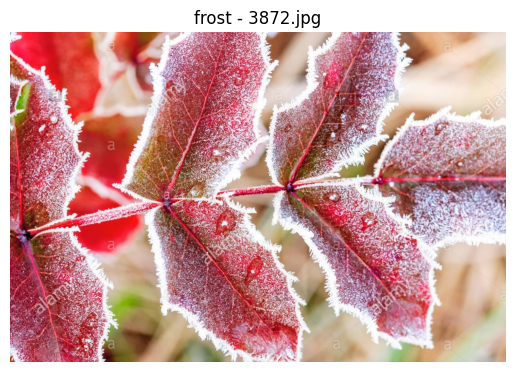

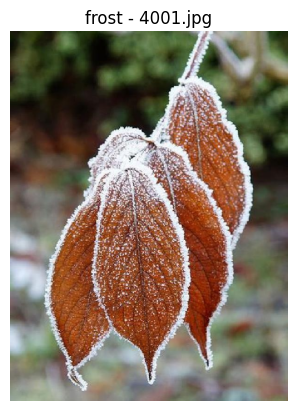

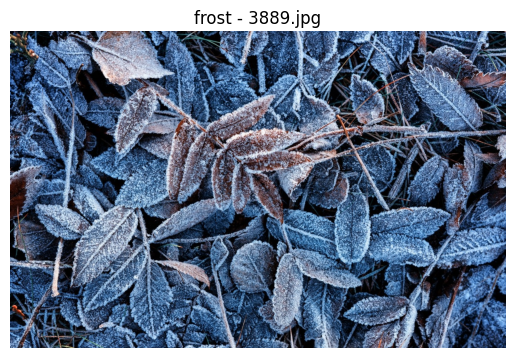

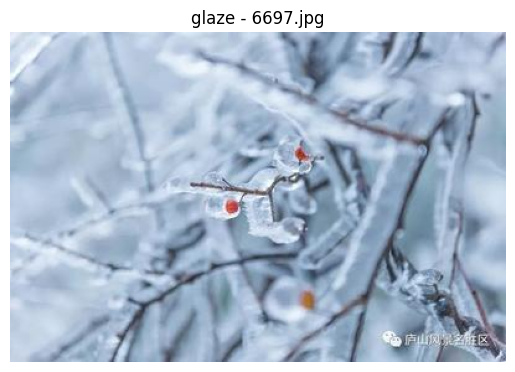

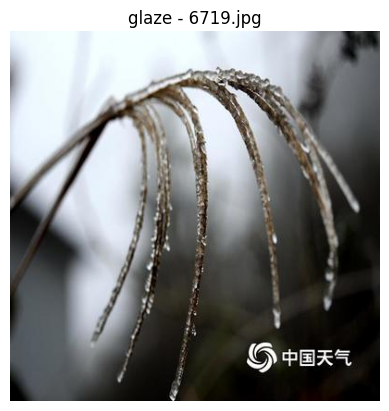

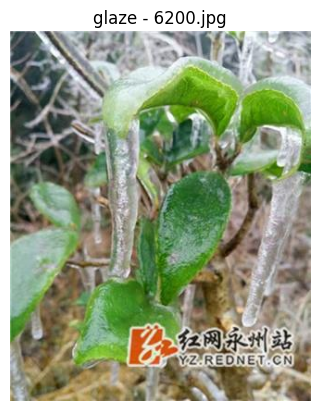

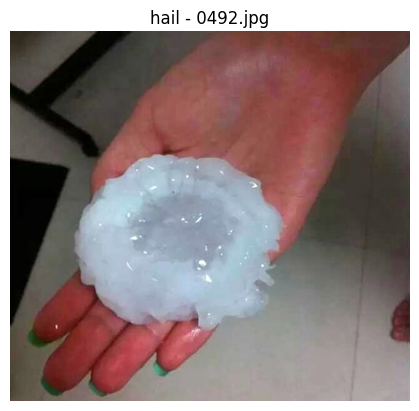

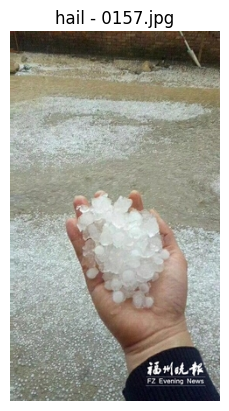

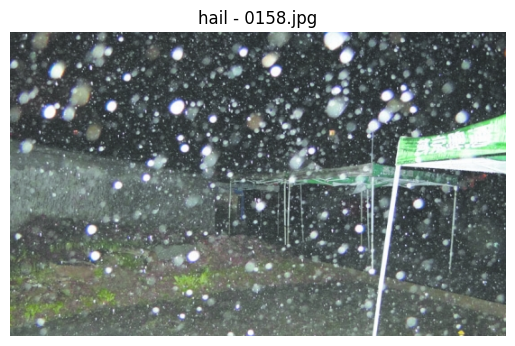

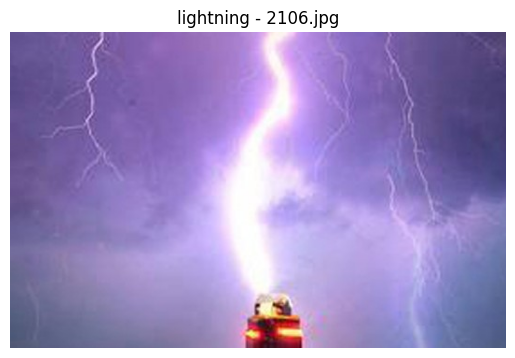

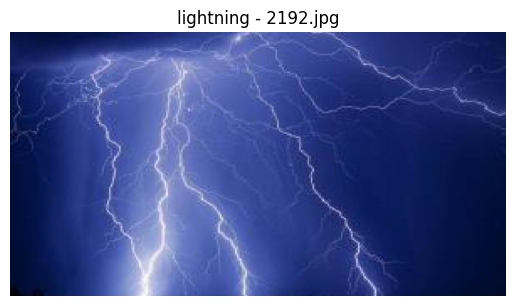

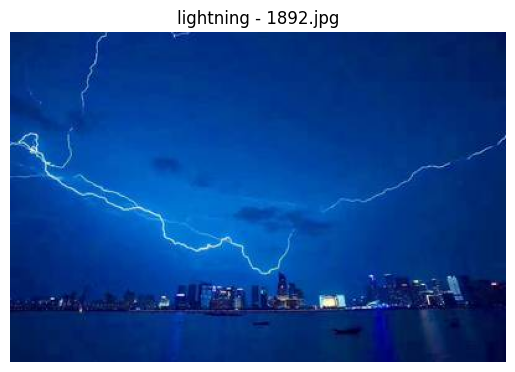

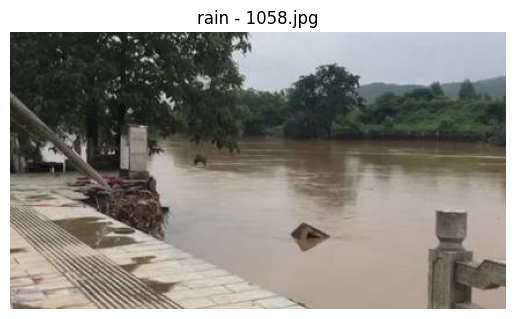

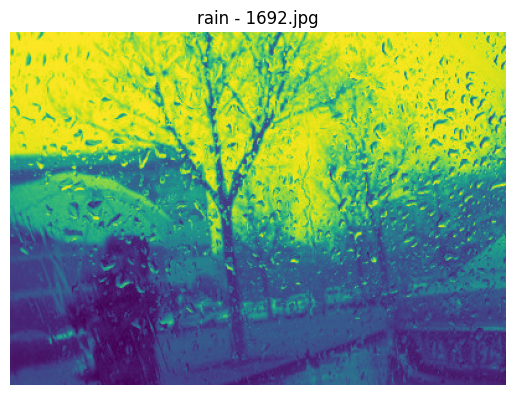

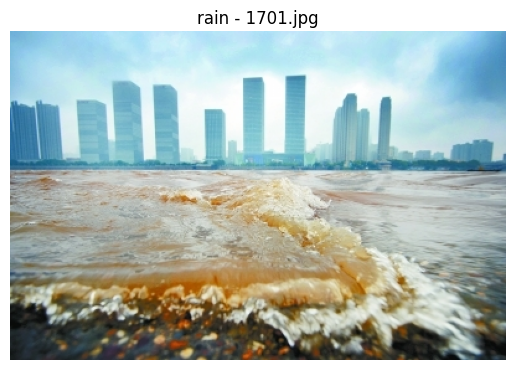

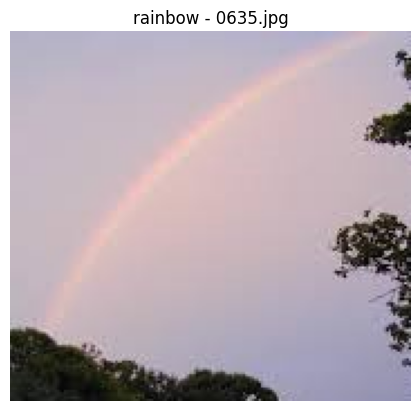

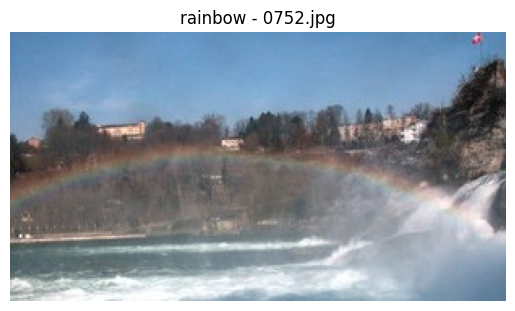

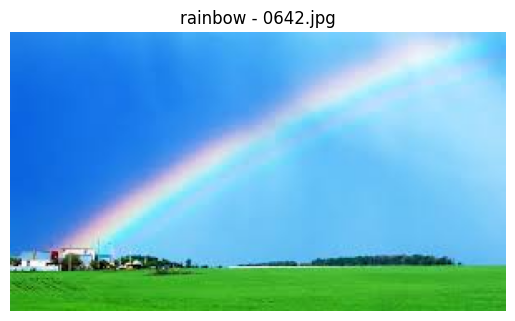

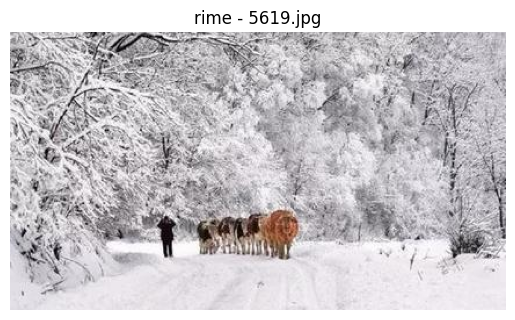

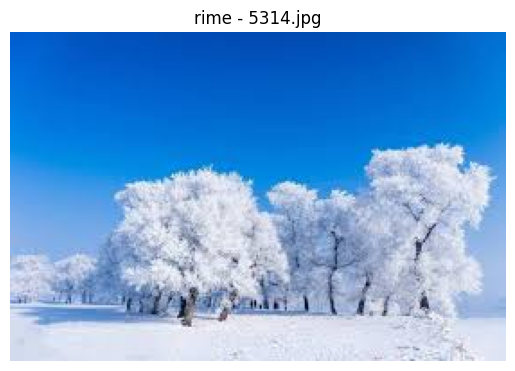

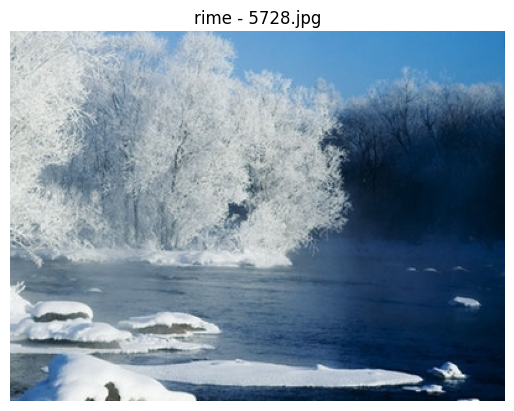

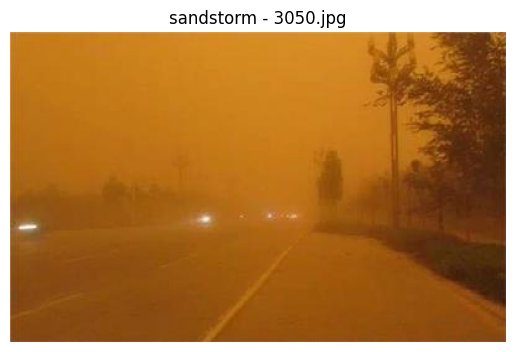

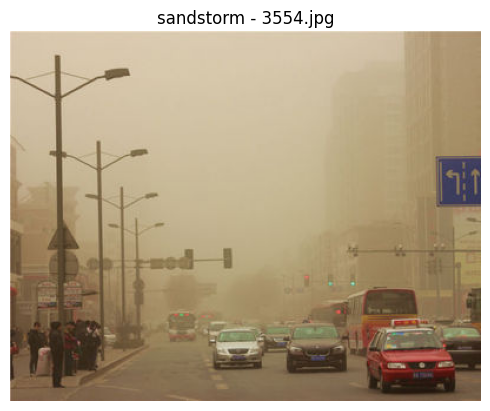

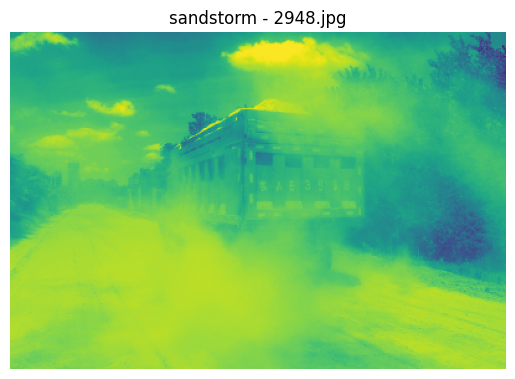

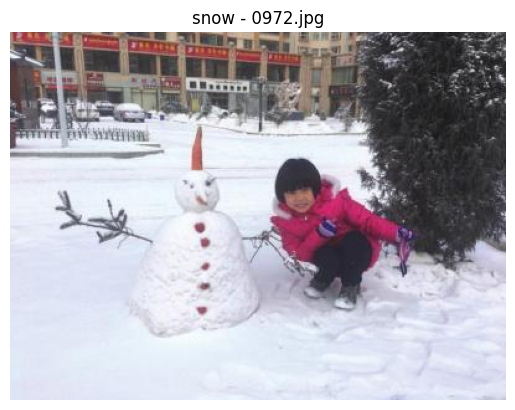

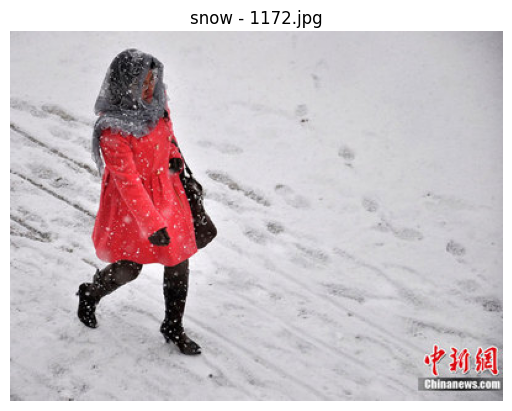

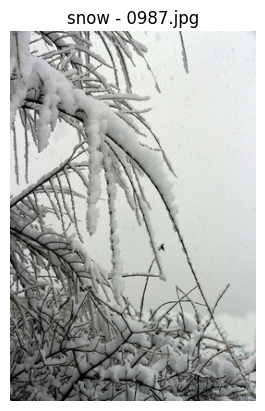

In [9]:
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    files = os.listdir(folder_path)
    sample_files = random.sample(files, k=3)
    for fname in sample_files:
            img_path = os.path.join(folder_path, fname)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{folder} - {fname}')
            plt.show()

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50pre 

flip_layer = RandomFlip("horizontal")
rotation_layer = RandomRotation(factor=15/360, fill_mode="reflect") 
translation_layer = RandomTranslation(height_factor=0.12, width_factor=0.12, fill_mode="reflect")
zoom_layer = RandomZoom(height_factor=0.10, width_factor=0.10, fill_mode="reflect")
def augment_and_preprocess(image, label,pre):
    image = flip_layer(image)
    image = rotation_layer(image)
    image = translation_layer(image)
    image = zoom_layer(image)
    image = pre(image)
    return image, label

def preprocess_only(image, label,pre):
    return pre(image), label

dataset_dir = r"C:\Users\LENOVO\Downloads\Dl project\dataset"
train_dataset = tf.keras.utils.image_dataset_from_directory(
dataset_dir, validation_split = .2, subset = 'training', seed=42, 
    image_size=(150, 150), batch_size=32, label_mode='int'
)
Validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir, validation_split = .2, subset = 'validation', seed=42, 
    image_size=(150, 150), batch_size=32, label_mode='int'
)
val_test_batches = tf.data.experimental.cardinality(Validation_dataset)
test_batches = val_test_batches // 2
validation_batches = val_test_batches - test_batches
test_dataset = Validation_dataset.take(test_batches)
validation_dataset = Validation_dataset.skip(test_batches)
    
    
def get_data(pre):
    def augment_map(image, label):
        return augment_and_preprocess(image, label, pre)
        
    def preprocess_map(image, label):
        return preprocess_only(image, label, pre)
    train_dataset_final = (train_dataset
                           .map(augment_map, num_parallel_calls=tf.data.AUTOTUNE)
                           .cache()
                           .shuffle(1000)
                           .prefetch(tf.data.AUTOTUNE)
                          )
    
    validation_dataset_final = (validation_dataset
                                .map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)
                                .cache()
                                .prefetch(tf.data.AUTOTUNE)
                               )
    test_dataset_final = (test_dataset
                                .map(preprocess_map, num_parallel_calls=tf.data.AUTOTUNE)
                                .cache()
                                .prefetch(tf.data.AUTOTUNE)
                               )
    return train_dataset_final, validation_dataset_final, test_dataset_final

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [11]:
for images, labels in train_dataset.take(1):
    print("Batch shape:", images.shape)
class_names = train_dataset.class_names

Batch shape: (32, 150, 150, 3)


In [12]:
class_names = train_dataset.class_names
print("Classes:", class_names)

Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


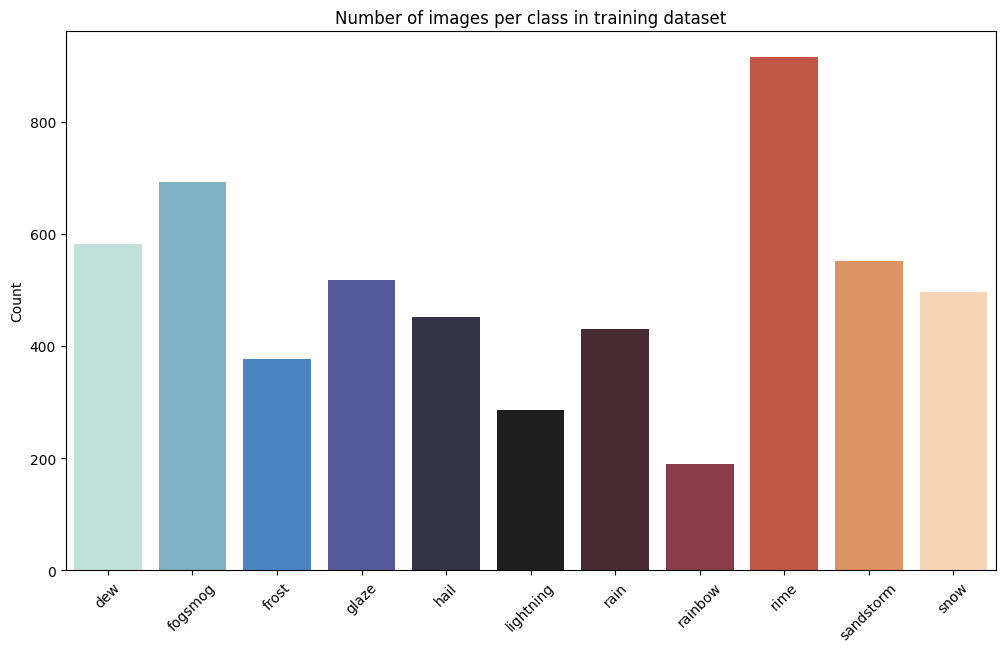

In [13]:
all_labels = []
class_names = train_dataset.class_names

for _, labels in train_dataset:
    all_labels.extend(labels.numpy())  


plt.figure(figsize=(12,7))
sns.countplot(x=all_labels, hue=all_labels, palette="icefire", legend=False)
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)
plt.title("Number of images per class in training dataset")
plt.ylabel("Count")
plt.show()

In [14]:
from tensorflow.keras.layers import Rescaling
normalization_layer = Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
Validation_dataset = Validation_dataset.map(lambda x, y: (normalization_layer(x), y))

Helper functions

In [15]:
def Plot_Training_Loss_Curves(history):
    #plt.plot(history['train_loss'],label='Training loss')
    #plt.plot(history['val_loss'],label='Validation loss')
    plt.plot(history.history['loss'],label='Training loss')
    plt.plot(history.history['val_loss'],label='Validation loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
def Plot_Training_Accuracy_Curves(history):
    #plt.plot(history['train_acc'],label='Training Accuracy')
    #plt.plot(history['val_acc'],label='Validation Accuracy')
    plt.plot(history.history['accuracy'],label='Training Accuracy')
    plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoches')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [16]:
def Calculate_Confusion_Matrix(y_true,y_pred,average='macro'):
    accuracy=np.mean( y_true == y_pred )
    precision=precision_score(y_true,y_pred,average=average,zero_division=0)
    recall=recall_score(y_true,y_pred,average=average,zero_division=0)
    f1=f1_score(y_true,y_pred,average=average,zero_division=0)
    return accuracy, precision, recall, f1

In [17]:
def Plot_Confuision_Matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,  yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def Plot_Roc_Auc_Curve(y_true,y_score,class_names):
    y_true_bin=label_binarize(y_true,classes=range(len(class_names)))
    plt.figure(figsize=(8,6))     
    for i, class_name in enumerate(class_names):
      fpr ,tpr , _ =roc_curve(y_true_bin[ :,i],y_score[:,i])
      roc_auc = auc(fpr, tpr)
      plt.plot(fpr,tpr ,label=f"{class_name}(Auc={roc_auc:.2f})")
     
    plt.plot([0,1],[0,1],'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

Resnet 50 pre-trained model with transfer learning

In [18]:
from tensorflow.keras.applications.resnet50 import preprocess_input as  resnet50pre
from tensorflow.keras.regularizers import l2
resnet_model = Sequential()
pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
    name="resnet50",
)
for layer in pretrained_model.layers[:-30]:
    layer.trainable = False
for layer in pretrained_model.layers[-30:]:
    layer.trainable = True
resnet_model.add(pretrained_model)
resnet_model.add(Dense(512,activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(11,activation='softmax',kernel_regularizer=l2(0.001)))
my_callbacks  = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

In [19]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,642,443 (94.00 MB)

 Trainable params: 15,504,907 (59.15 MB)

 Non-trainable params: 9,137,536 (34.86 MB)

In [20]:
resnet_model.compile(optimizer=Adam(learning_rate=0.00001),loss='crossentropy',metrics=['accuracy'])

In [ ]:
train,val,test = get_data(resnet50pre)
epochs=50
history = resnet_model.fit(
    train, 
    validation_data = val,
    epochs = epochs,
    callbacks=my_callbacks
)
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

Epoch 1/50
 92/172 ━━━━━━━━━━━━━━━━━━━━ 1:09 866ms/step - accuracy: 0.2049 - loss: 2.2642

In [ ]:
y_score = resnet_model.predict(test)
y_pred = np.argmax(y_score, axis=1)
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())
y_true = np.concatenate(y_true_list, axis=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 691ms/step


In [ ]:
accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true,y_pred)
print ("accuracy =", accuracy) 
print ("precision =", precision) 
print ("recall =", recall)
print ("f1 =" ,f1)

accuracy = 0.8556547619047619
precision = 0.872768614547569
recall = 0.8517384541644062
f1 = 0.8594783458064886


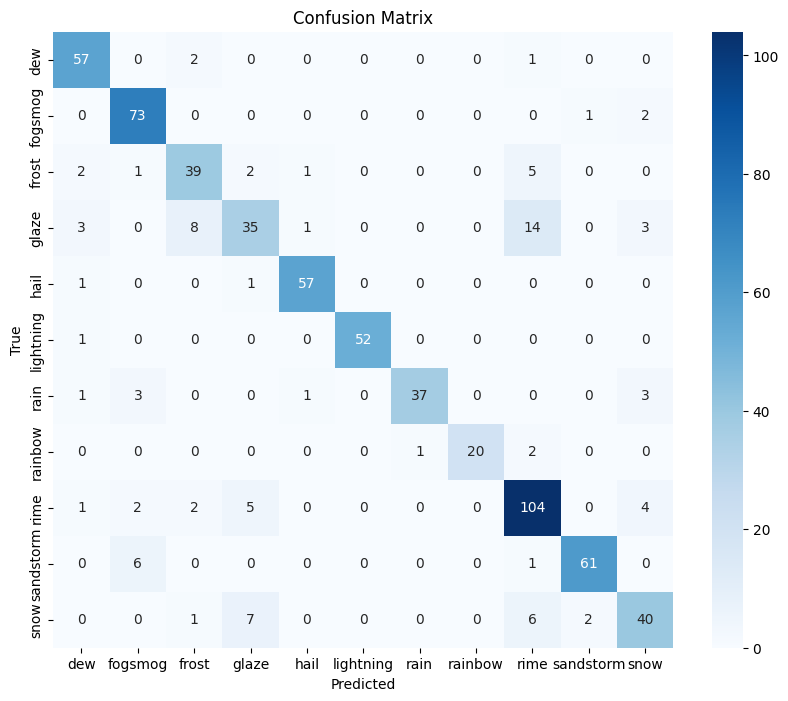

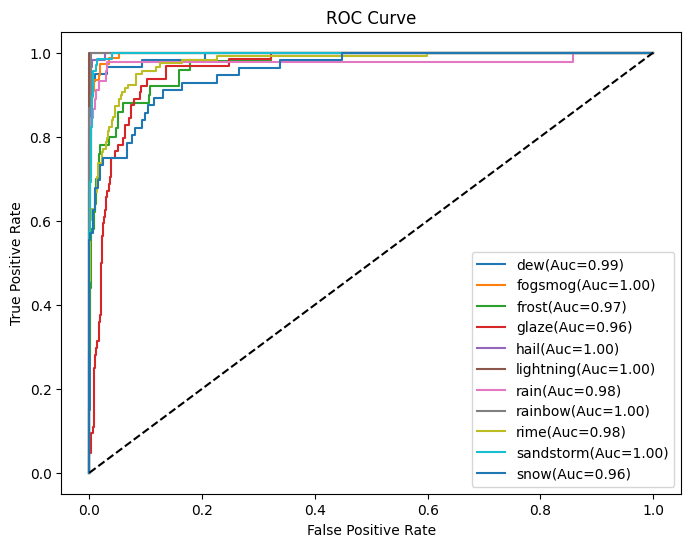

In [ ]:
class_names = train_dataset.class_names
Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)

mobile net

C:\Users\maria\AppData\Local\Temp\ipykernel_34668\797623158.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model = tf.keras.applications.MobileNet(


Epoch 1/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 85s 401ms/step - accuracy: 0.2002 - loss: 2.7496 - val_accuracy: 0.4829 - val_loss: 1.6608
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 68s 370ms/step - accuracy: 0.4246 - loss: 1.7929 - val_accuracy: 0.6386 - val_loss: 1.1746
Epoch 3/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 66s 383ms/step - accuracy: 0.5561 - loss: 1.3426 - val_accuracy: 0.7071 - val_loss: 0.9394
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 51s 295ms/step - accuracy: 0.6479 - loss: 1.0603 - val_accuracy: 0.7443 - val_loss: 0.8131
Epoch 5/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.7075 - loss: 0.9027 - val_accuracy: 0.7700 - val_loss: 0.7249
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 45s 260ms/step - accuracy: 0.7441 - loss: 0.7783 - val_accuracy: 0.7829 - val_loss: 0.6749
Epoch 7/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.7752 - loss: 0.6921 - val_accuracy: 0.7971 - val_loss: 0.6329
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 79s 275ms/step - accuracy: 0.8067 - loss: 0

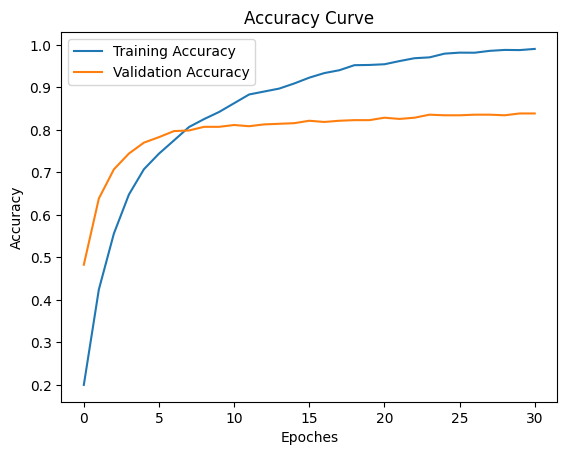

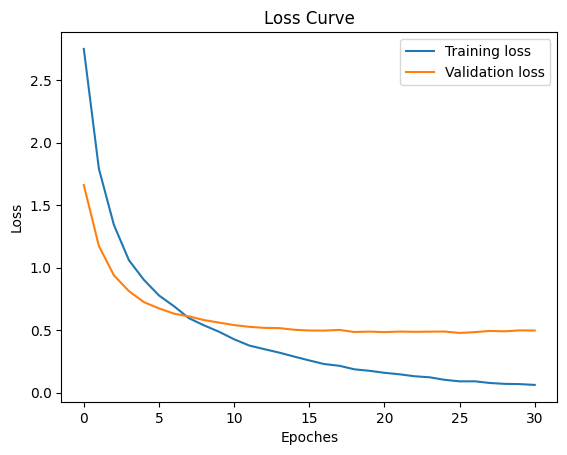

In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as MobileNet_pre
mobileNet_model = Sequential()
pretrained_model = tf.keras.applications.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(150,150,3),
    pooling='avg',
    classes=11,
    classifier_activation="softmax",
    name="mobilenet",
)
for layer in pretrained_model.layers[:-30]:
    layer.trainable = False
for layer in pretrained_model.layers[-30:]:
    layer.trainable = True
mobileNet_model.add(pretrained_model)
mobileNet_model.add(Dense(512,activation='relu'))
mobileNet_model.add(Dropout(0.5))
mobileNet_model.add(Dense(11,activation='softmax'))
my_callbacks  = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
mobileNet_model.compile(optimizer=Adam(learning_rate=0.00001),loss='crossentropy',metrics=['accuracy'])
train,val,test = get_data(MobileNet_pre)
history = mobileNet_model.fit(
    train,
    validation_data=val,
    epochs=50,
    callbacks=my_callbacks,
    verbose=1
)
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

In [ ]:
y_score = mobileNet_model.predict(test)
y_pred = np.argmax(y_score, axis=1)
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())
y_true = np.concatenate(y_true_list, axis=0)

21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 184ms/step


In [ ]:
accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true,y_pred)
print ("accuracy =", accuracy) 
print ("precision =", precision) 
print ("recall =", recall)
print ("f1 =" ,f1)

accuracy = 0.8273809523809523
precision = 0.8419127693052574
recall = 0.8295217813591134
f1 = 0.8322518010639833


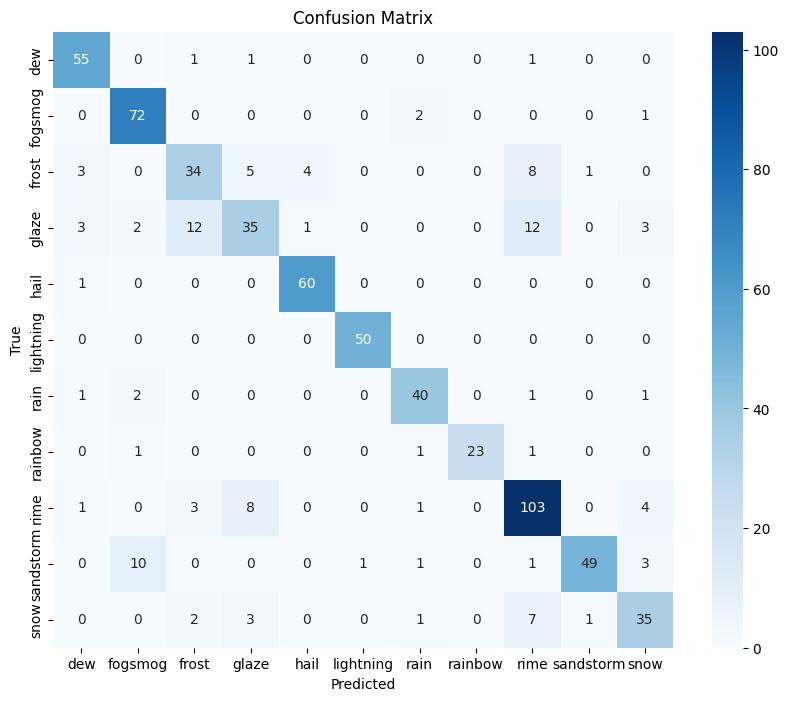

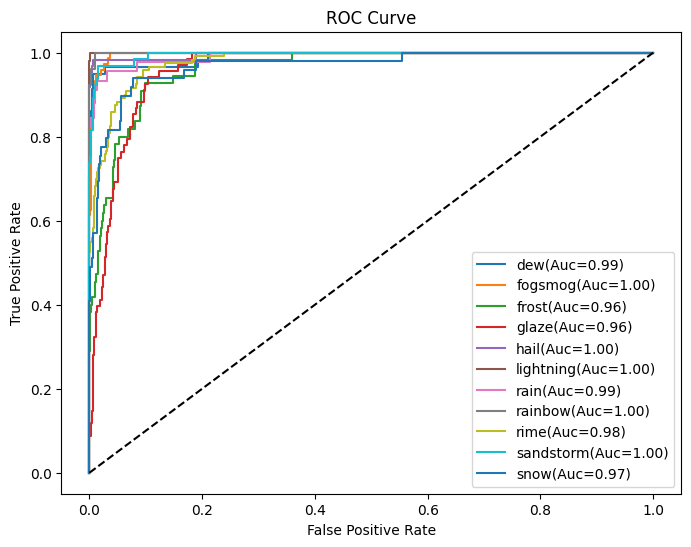

In [ ]:
class_names = train_dataset.class_names
Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)

## VGG19 model

In [43]:
import tensorflow as tf

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def VGG19_from_scratch(input_shape=(128, 128, 3), num_classes=11):
    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 4
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 5
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Classifier
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [46]:
flip_layer = tf.keras.layers.RandomFlip("horizontal_and_vertical")
rotation_layer = tf.keras.layers.RandomRotation(0.2)
translation_layer = tf.keras.layers.RandomTranslation(0.2, 0.2)
zoom_layer = tf.keras.layers.RandomZoom(0.2)
# تحميل البيانات (غيرت image_size إلى (150, 150) عشان يطابق)
dataset_dir = r"C:\Users\LENOVO\Downloads\Dl project\dataset"
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(150, 150),  # غيرت عشان يطابق
    batch_size=32,
    label_mode='int'
)
validation_dataset_full = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(150, 150),  # غيرت عشان يطابق
    batch_size=32,
    label_mode='int'
)
val_test_batches = tf.data.experimental.cardinality(validation_dataset_full)
test_batches = val_test_batches // 2
validation_batches = val_test_batches - test_batches
test_dataset = validation_dataset_full.take(test_batches)
validation_dataset = validation_dataset_full.skip(test_batches)

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Found 6862 files belonging to 11 classes.
Using 1372 files for validation.


In [47]:
train, val, test = get_data(pre=lambda x: x/255.0)

# إنشاء النموذج
model = VGG19_from_scratch(input_shape=(150, 150, 3), num_classes=11)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipvalue=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("--- VGG19 Model summary ---")
model.summary()

--- VGG19 Model summary ---


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 9, 9, 256)      │             

 Total params: 2,495,531 (9.52 MB)

 Trainable params: 2,492,587 (9.51 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [48]:

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_vgg19_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
# تدريب النموذج
history = model.fit(
    train,
    validation_data=val,
    epochs=5,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

Epoch 1/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.4222 - loss: 1.7528 - val_accuracy: 0.1214 - val_loss: 5.2507 - learning_rate: 1.0000e-04
Epoch 2/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.5420 - loss: 1.3479 - val_accuracy: 0.2729 - val_loss: 2.3927 - learning_rate: 1.0000e-04
Epoch 3/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.5844 - loss: 1.2185 - val_accuracy: 0.5829 - val_loss: 1.2026 - learning_rate: 1.0000e-04
Epoch 4/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 273s 2s/step - accuracy: 0.6079 - loss: 1.1541 - val_accuracy: 0.6043 - val_loss: 1.1369 - learning_rate: 1.0000e-04
Epoch 5/5
172/172 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - accuracy: 0.6297 - loss: 1.0675 - val_accuracy: 0.6029 - val_loss: 1.2315 - learning_rate: 1.0000e-04


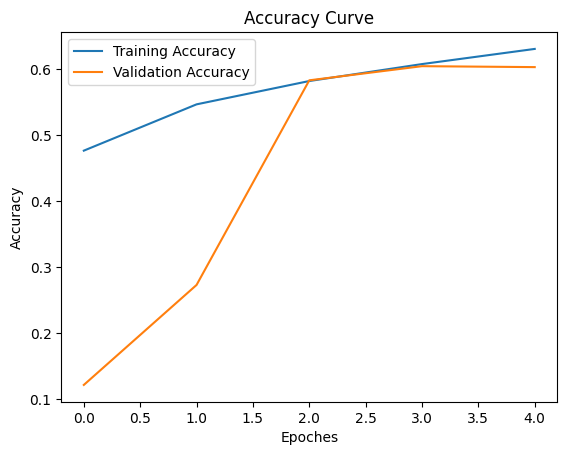

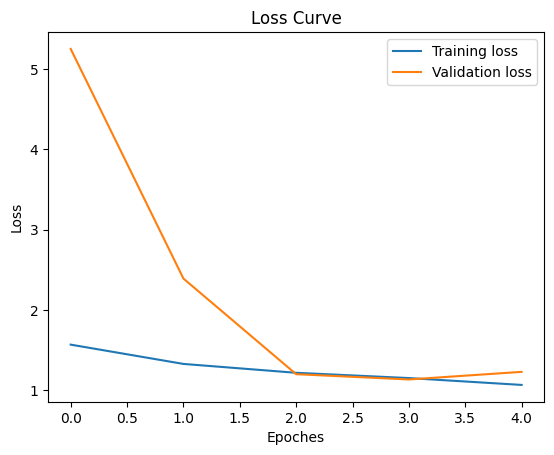

In [49]:
Plot_Training_Accuracy_Curves(history)
Plot_Training_Loss_Curves(history)

In [50]:
# --- Predictions on Test Set ---
y_score = model.predict(test)
y_pred = np.argmax(y_score, axis=1)


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step


In [51]:
# --- Extract True Labels ---
y_true_list = []
for images, labels in test:
    y_true_list.append(labels.numpy())

y_true = np.concatenate(y_true_list, axis=0)



--- Test Metrics ---
Accuracy = 0.5699404761904762
Precision = 0.5674039239655845
Recall = 0.5436978256389693
F1 Score = 0.543870424536802


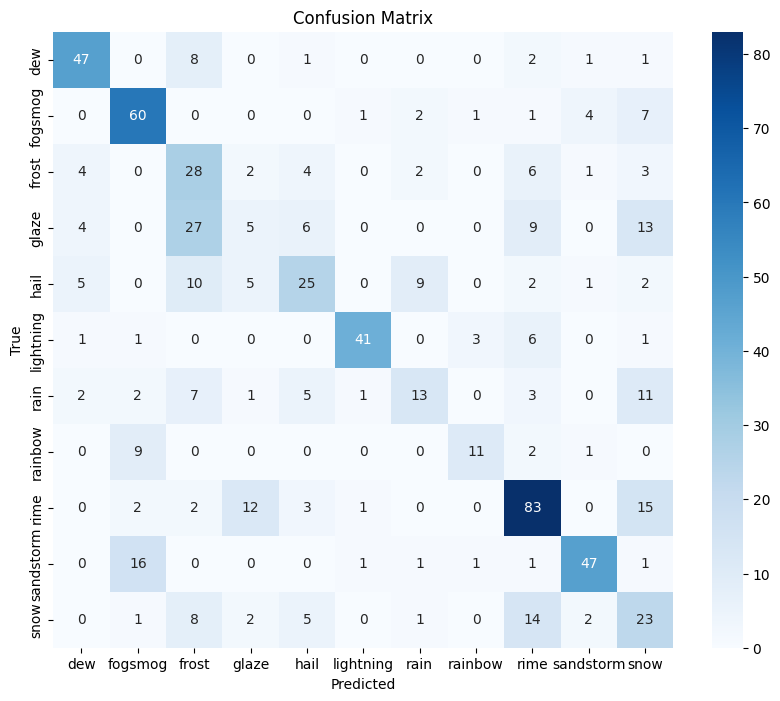

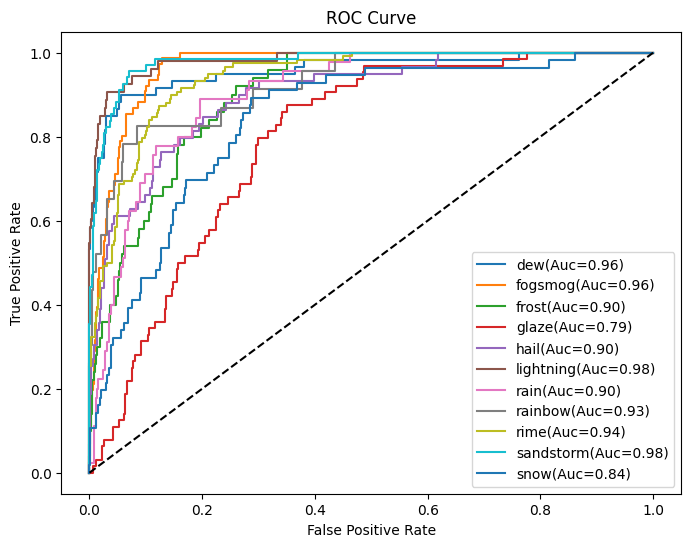

In [52]:
# --- Evaluate with Helper Functions ---

accuracy, precision, recall, f1 = Calculate_Confusion_Matrix(y_true, y_pred)

print("\n--- Test Metrics ---")
print("Accuracy =", accuracy)
print("Precision =", precision)
print("Recall =", recall)
print("F1 Score =", f1)


class_names = train_dataset.class_names

Plot_Confuision_Matrix(y_true, y_pred, class_names)
Plot_Roc_Auc_Curve(y_true, y_score, class_names)
